# Data Analysis of Job tasks
Using Natural Language Processing to categorize job task descriptions into 21 predefined categories and performing frequency analysis. Additionally, using K-Means clustering to see if the clusters generated have zero overlap to ensure that the data is viable (atleast to an extent).

Name: Joshua Hizgiaev<br>
Research: Analyzing growth of data science in the US job market

In [31]:
!pip install nltk
!pip install transformers
!pip install seaborn
!pip install pandas numpy scipy matplotlib
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393091 sha256=40bce7ca4e3a3e90584c9da75daa69f13c22319e3a7fe96e9189386e787f66cb
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [24]:
# Add standard data science pacakges
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# load google drive with excel sheet
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# load excel sheet data into google colab
path = '/content/drive/MyDrive/Data/Task Analysis/ONET/Task Statements.xlsx'
task_excel = pd.DataFrame(pd.read_excel(path))
task_csv = task_excel.to_csv("/content/drive/MyDrive/Data/Task Analysis/ONET/Task Statements.csv",index=None,header=True)
df = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Data/Task Analysis/ONET/Task Statements.csv"))
print(df.shape[0])
df.head()

19265


,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent


# Preprocessing:
1. Getting rid of unneeded columns
2. Getting rid of duplicates if any
3. Getting rid of missing values if any
4. Convert dates to date time python objects

In [27]:
df = df.drop(['O*NET-SOC Code','Task ID','Domain Source','Incumbents Responding'],axis=1).drop_duplicates().dropna(how='all')
df['Date'] = pd.to_datetime(df.Date)
df['Date'] = df['Date'].dt.strftime('%m-%Y')
print(df.shape[0])
df.head()

19265


,Title,Task,Task Type,Incumbents Responding,Date
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014


In [28]:
# Find the total amount of tasks that are core, supplemental, or neither
# this will help in understanding how the data was made, as well as what majority of the data is place or
# if it is evenly distributed
core_df = df[df['Task Type'] == 'Core']
supp_df = df[df['Task Type'] == 'Supplemental']
neither_df = df[df['Task Type'].isna()]
print("The number of tasks identified as core: {}".format(core_df.shape[0]))
print("The number of tasks identified as supplemental: {}".format(supp_df.shape[0]))
print("The number of tasks identified as neither core or supplemental: {}".format(neither_df.shape[0]))

The number of tasks identified as core: 13225
The number of tasks identified as supplemental: 4728
The number of tasks identified as neither core or supplemental: 1312


### It is clear that there is an uneven number of core, supplemental, and tasks classified as neither
I now need to determine how exactly I should utilize this data, and how to approach it with NLP. I will first begin with **NOT** concidering occupation, meaning that I will only need to perform similarity clustering for tasks only. With that decided, I will perform NLP with the data as a whole.


In [29]:
# preprocess text data for NLP, I will begin with taking into
# account the WHOLE dataset, and then will work on core, supplemental, and neither later
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

X = df['Task'].tolist()

documents = []
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
for sen in range(0,len(X)):
  # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)

df['Processed Tasks'] = np.array(documents)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...
...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA


vectorizer = TfidfVectorizer()
processed_text = df['Processed Tasks'].tolist()
X = vectorizer.fit_transform(processed_text)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

k = 20
kmeans = KMeans(n_clusters = k,init='k-means++',max_iter=300,n_init=15, random_state=42)
kmeans.fit(X_pca)
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)
df['Labels'] = kmeans.labels_
clusters = kmeans.labels_.tolist()
texts_df = pd.DataFrame({'text':processed_text,'cluster':clusters})
texts_df

KeyboardInterrupt: ignored

In [ ]:
texts_df.to_excel('/content/drive/MyDrive/Data/Task Analysis/Generated Data/Text Clustering Data.xlsx')
X_pca.shape

(19265, 2)

In [15]:
%matplotlib inline

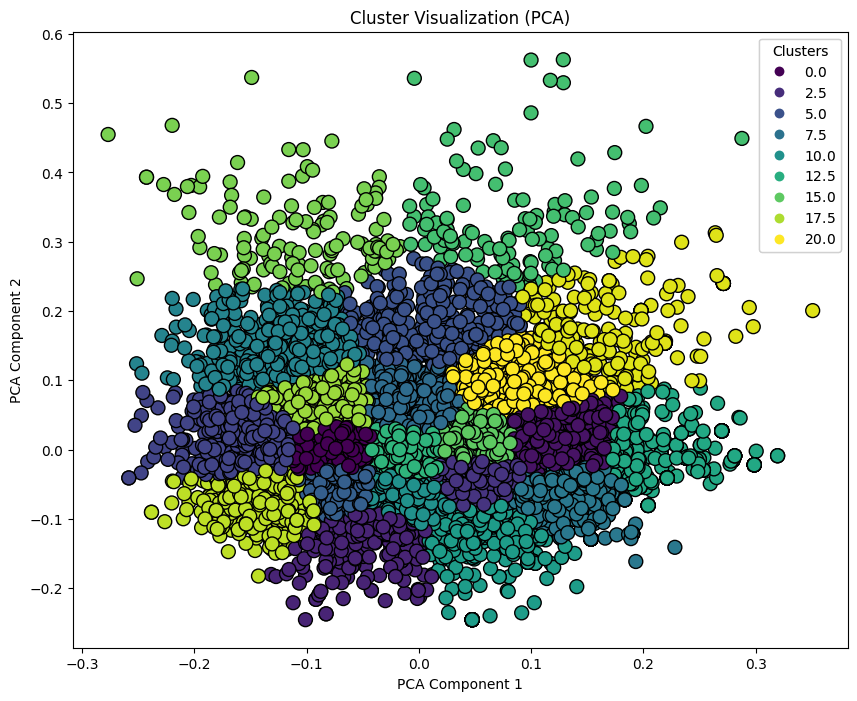

In [ ]:
pca_df = pd.DataFrame(data=X_pca, columns=["PCA1", "PCA2"])
pca_df["cluster"] = clusters
plt.figure(figsize=(10, 8))
ax = plt.gca()
scatter = ax.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["cluster"], cmap="viridis", edgecolors='k', s=100)
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization (PCA)")
plt.show()

### Now that task statements are assigned cluster labels I now want to do text classification to appoint every task description one of the following categories:

1. Technical/Engineering: Tasks involving designing, testing, and installation of devices, software, or complex equipment.

2. Management/Leadership: Tasks related to directing, overseeing, and organizing teams, projects, or departments.

3. Administrative: Tasks associated with scheduling, record-keeping, data entry, and reporting.

4. Marketing/Sales: Tasks related to promoting, selling, and creating demand for products or services.

5. Customer Service: Tasks involving interacting with customers, resolving concerns, and providing support.

6. Research/Analysis: Tasks related to gathering information, conducting studies, and evaluating findings.

7. Production: Tasks focused on manufacturing, assembly, and operations of products or machines.

8. Quality Assurance/Control: Tasks related to ensuring quality, adherence to standards, and improvement activities.

9. Human Resources: Tasks dealing with recruitment, hiring, employee relations, and training.

10. Finance/Accounting: Tasks focused on financial management, budgeting, and revenues.

11. Information Technology: Tasks associated with managing and maintaining digital systems, networks, and databases.

12. Maintenance/Repair: Tasks involving the upkeep and repair of equipment, buildings, or machinery.

13. Logistics/Supply chain: Tasks related to managing inventory, transportation, and distribution.

14. Creative/Design: Tasks involving design, creation, and innovation in various fields such as art, graphics, or products.

15. Education/Training: Tasks focused on teaching, mentoring, and skill development.

16. Health/Medical: Tasks related to patient care, treatment, and medical procedures.

17. Legal/Compliance: Tasks associated with ensuring adherence to laws and regulations.

18. Project Management: Tasks focused on planning, execution, and delivery of projects.

19. Security/Safety: Tasks related to the protection of people, property, or information.

20. Environment/Sustainability: Tasks focused on conservation, waste management, and eco-friendly processes.

# How does one do this?

Hugging face has a pretrained zero-shot classification model, so I will just feed my data into its pipeline with descriptive categories to get more accurate results.

In [ ]:
from transformers import pipeline

categories = [
    "TE, designing, testing, and installation of devices, software, or complex equipment",
    "Management/Leadership, directing, overseeing, and organizing teams, projects, or departments",
    "Administrative, scheduling, record-keeping, data entry, and reporting",
    "Marketing/Sales, promoting, selling, and creating demand for products or services",
    "Customer Service, interacting with customers, resolving concerns, and providing support",
    "Research, gathering information, conducting studies, and evaluating findings, creating machine learning models, and data analysis",
    "Production, manufacturing, assembly, and operations of products or machines",
    "Quality Assurance/Control, ensuring quality, adherence to standards, and improvement activities",
    "HR, recruitment, hiring, training, employee relations",
    "Finance/Accounting, financial management, budgeting, and revenues",
    "IT, managing and maintaining digital systems, networks, and databases",
    "Maintenance/Repair, upkeep and repair of equipment, buildings, or machinery.",
    "Logistics/Supply chain, managing inventory, transportation, and distribution",
    "Creative/Design, design, creation, and innovation in various fields such as art, graphics, or products",
    "Education/Training, teaching, mentoring, and skill development",
    "Health/Medical, patient care, treatment, and medical procedures",
    "Legal/Compliance, ensuring adherence to laws and regulations",
    "Project Management, planning, execution, and delivery of projects",
    "Security/Safety, protection of people, property, or information",
    "Environment/Sustainability, conservation, waste management, and eco-friendly processes",
]

nlp = pipeline("zero-shot-classification", device=0)
# Function to categorize descriptions
def categorize_description(description: str) -> str:
    result = nlp(description, categories,multi_label=False)
    return result["labels"][0]
df["category"] = df["Processed Tasks"].apply(categorize_description)
df.to_excel('/content/drive/MyDrive/Data/Task Analysis/Generated Data/Categorized Tasks.xlsx')
df

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...,18,"Finance/Accounting, financial management, budg..."
1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...,0,"Management/Leadership, directing, overseeing, ..."
2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...,18,"Research, gathering information, conducting st..."
3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...,18,"Management/Leadership, directing, overseeing, ..."
4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...,6,"Finance/Accounting, financial management, budg..."
...,...,...,...,...,...,...,...,...
19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...,13,"Logistics/Supply chain, managing inventory, tr..."
19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...,17,"Maintenance/Repair, upkeep and repair of equip..."
19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...,13,"Maintenance/Repair, upkeep and repair of equip..."
19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...,5,"Logistics/Supply chain, managing inventory, tr..."


### Now we have accuratley labled labeled job tasks corresponding to time series, now we can finally perform some standard analysis. Starting with frequency, distribution, and growth of frequency over time.

In [3]:
# In order to skip fine tuning one shot classification again I will simply assign the excel sheet generated and work on
# analysis from here
path = '/content/drive/MyDrive/Data/Task Analysis/Generated Data/Categorized Tasks.xlsx'
cat_df = pd.DataFrame(pd.read_excel(path))
cat_df

,Unnamed: 0,Title,Task,Task Type,Incumbents Responding,Date,Processed Tasks,Labels,category
0,0,Chief Executives,Direct or coordinate an organization's financi...,Core,87.0,07-2014,direct or coordinate an organization financial...,18,"Finance/Accounting, financial management, budg..."
1,1,Chief Executives,Appoint department heads or managers and assig...,Core,87.0,07-2014,appoint department head or manager and assign ...,0,"Management/Leadership, directing, overseeing, ..."
2,2,Chief Executives,Analyze operations to evaluate performance of ...,Core,87.0,07-2014,analyze operation to evaluate performance of c...,18,"Research, gathering information, conducting st..."
3,3,Chief Executives,"Direct, plan, or implement policies, objective...",Core,87.0,07-2014,direct plan or implement policy objective or a...,18,"Management/Leadership, directing, overseeing, ..."
4,4,Chief Executives,"Prepare budgets for approval, including those ...",Core,87.0,07-2014,prepare budget for approval including those fo...,6,"Finance/Accounting, financial management, budg..."
...,...,...,...,...,...,...,...,...,...
19260,19260,"Tank Car, Truck, and Ship Loaders",Unload cars containing liquids by connecting h...,Supplemental,85.0,08-2019,unload car containing liquid by connecting hos...,13,"Logistics/Supply chain, managing inventory, tr..."
19261,19261,"Tank Car, Truck, and Ship Loaders","Clean interiors of tank cars or tank trucks, u...",Supplemental,85.0,08-2019,clean interior of tank car or tank truck using...,17,"Maintenance/Repair, upkeep and repair of equip..."
19262,19262,"Tank Car, Truck, and Ship Loaders",Lower gauge rods into tanks or read meters to ...,Supplemental,85.0,08-2019,lower gauge rod into tank or read meter to ver...,13,"Maintenance/Repair, upkeep and repair of equip..."
19263,19263,"Tank Car, Truck, and Ship Loaders",Operate conveyors and equipment to transfer gr...,Supplemental,85.0,08-2019,operate conveyor and equipment to transfer gra...,5,"Logistics/Supply chain, managing inventory, tr..."


In [86]:
from itertools import groupby
# Create a mapping to replace the really long descriptions:
cat_mapping = {
    "TE, designing, testing, and installation of devices, software, or complex equipment":'Technical/Engineering',
    "Management/Leadership, directing, overseeing, and organizing teams, projects, or departments":'Management/Leadership',
    "Administrative, scheduling, record-keeping, data entry, and reporting":'Administrative',
    "Marketing/Sales, promoting, selling, and creating demand for products or services":'Marketing/Sales',
    "Customer Service, interacting with customers, resolving concerns, and providing support":'Customer Service',
    "Research, gathering information, conducting studies, and evaluating findings":'Research',
    "Production, manufacturing, assembly, and operations of products or machines":'Production',
    "Quality Assurance/Control, ensuring quality, adherence to standards, and improvement activities":'Quality Assurance',
    "HR, recruitment, hiring, training, employee relations":'Human Relations',
    "Finance/Accounting, financial management, budgeting, and revenues":'Finance/Accounting',
    "IT, managing and maintaining digital systems, networks, and databases":'Information Technology',
    "Maintenance/Repair, upkeep and repair of equipment, buildings, or machinery.":'Maintenance/Repair',
    "Logistics/Supply chain, managing inventory, transportation, and distribution":'Logistics/Supply Chain',
    "Creative/Design, design, creation, and innovation in various fields such as art, graphics, or products":'Creative/Design',
    "Education/Training, teaching, mentoring, and skill development":'Education/Training',
    "Health/Medical, patient care, treatment, and medical procedures":'Health/Medical',
    "Legal/Compliance, ensuring adherence to laws and regulations":'Legal/Compliance',
    "Project Management, planning, execution, and delivery of projects":'Project Management',
    "Security/Safety, protection of people, property, or information":'Security/Safety',
    "Environment/Sustainability, conservation, waste management, and eco-friendly processes":'Environment/Sustainability',
    "Data Science/Analysis, perform data analysis and evaluation and create machine learning models":'Data Science/Analysis'
}
cat_df['category'] = cat_df['category'].replace(cat_mapping)
freq_df = cat_df.groupby(['Title','Date','category']).size().reset_index(name='Frequency')
freq_df.to_excel('/content/drive/MyDrive/Data/Task Analysis/Generated Data/frequency_output.xlsx')
freq_df.set_index('Date', inplace=True)
freq_df.index = pd.to_datetime(freq_df.index)
freq_df = freq_df.sort_index()
freq_df = freq_df.drop(['Title'],axis=1)
freq_df.to_excel('/content/drive/MyDrive/Data/Task Analysis/Generated Data/frequency_output.xlsx')
freq_df

,category,Frequency
Date,,
2004-12-01,Creative/Design,1
2004-12-01,Legal/Compliance,1
2004-12-01,Marketing/Sales,8
2004-12-01,Research,1
2004-12-01,Customer Service,2
...,...,...
2022-08-01,Environment/Sustainability,2
2022-08-01,Legal/Compliance,3
2022-08-01,Logistics/Supply Chain,7


# Frequency Analysis:
We have tasks with labels within a time series, now we can do the following:
- For the purposes of this analysis, we will be focusing on 3 key categories:
  - Technical/Engineering
  - Data Science/Analysis
  - Research

We will start by calculating its descriptive statistics for each data point, we will then do the same for the rest of the categories, then we can perform both a P-test and a T-test to compare to two categories if need be. After which, we will begin plotting individual frequency distribution over time to clearly see how the frequency of task are changing.



In [82]:
category_data = pd.DataFrame(columns=['Mean', 'STD', 'Min','Max','Median','Harmonic Mean', 'Geometric Mean'])

# It should be noted that this gets the data without taking into account the year, so it will get its stats over all avaliable time points
def add_stats(category_name):
  '''Will add a row of descriptive statistics based on category name to the category_data dataframe'''
  cat_data = freq_df[freq_df['category']==category_name]
  mean_frequency = cat_data['Frequency'].mean()
  std_frequency = cat_data['Frequency'].std()
  min_frequency = cat_data['Frequency'].min()
  max_frequency = cat_data['Frequency'].max()
  harmonic_mean_freq = sp.stats.hmean(cat_data['Frequency'])
  geometric_mean = sp.stats.gmean(cat_data['Frequency'])
  median = np.median(cat_data['Frequency'])
  category_data.loc[category_name] = [mean_frequency,std_frequency,min_frequency,max_frequency,median,harmonic_mean_freq,geometric_mean]

for item in cat_mapping.values():
  add_stats(item)

category_data


,Mean,STD,Min,Max,Median,Harmonic Mean,Geometric Mean
Technical/Engineering,2.321429,1.988106,1.0,11.0,2.0,1.494047,1.794856
Management/Leadership,1.932945,1.294904,1.0,9.0,2.0,1.444440,1.640455
Administrative,1.496314,1.161518,1.0,13.0,1.0,1.199268,1.300252
Marketing/Sales,2.549784,2.724429,1.0,16.0,1.0,1.438719,1.787107
Customer Service,2.161017,1.650669,1.0,10.0,2.0,1.475932,1.737086
Research,4.358382,3.957283,1.0,25.0,3.0,2.149858,3.008345
Production,3.131313,2.775301,1.0,14.0,2.0,1.685919,2.218496
Quality Assurance,1.878719,1.419533,1.0,13.0,1.0,1.381399,1.568636
Human Relations,1.410000,1.477747,1.0,12.0,1.0,1.090796,1.171894
Finance/Accounting,1.486486,1.406864,1.0,9.0,1.0,1.136664,1.236481


Above is the generalized frequency data of each job task category **based on month**, meaning that this is the data for each category for all its years (2006-2023) based on a monthly basis, hence why the numbers are so low. To get more indepth, we can now analyze this based on occupation and the frequency of categories that occurs **over time**. But first, we will plot the total frequency of all categories as a bar representation.

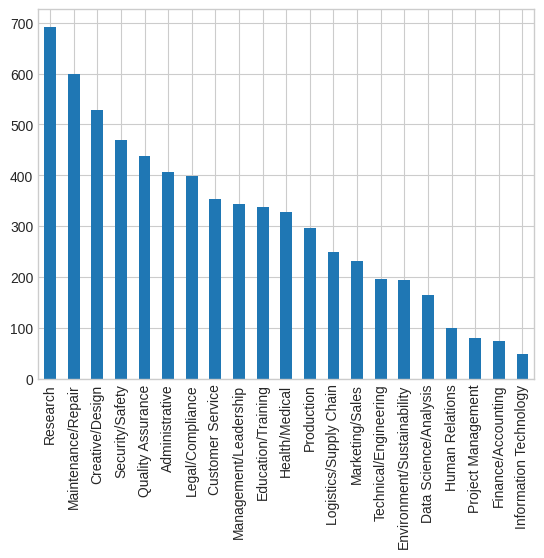

In [44]:
# Create a bar chart of all 21 categories and their total frequency over the years
freq_df['category'].value_counts().plot.bar()
plt.show()

As we can see, research is by far the most popular task among US jobs, and can closely attributed to the current US job market. Even beating essential infrastructure jobs such as Maintenance/Repair, Education, Logistics, and even general engineering jobs.

However, due to the close ties that Data Science and Analysis and Research are, if we add them together we will see an even greater proporation of jobs that require data analysis, research, and analysis all together. What I mean by analysis is purely in the data science context as specified when utilizing Zero Shot classification.

<ipython-input-45-abb1df3f3ad5>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


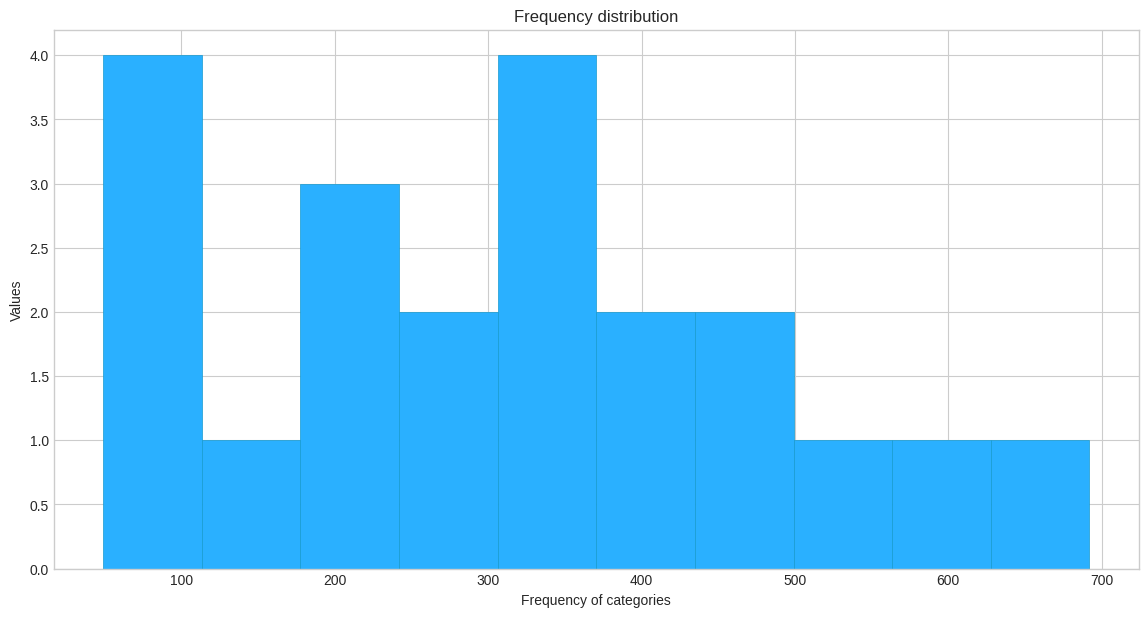

In [45]:
# Lets plot a histogram to see the general distribution of tasks
x = freq_df['category'].value_counts()
plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(x, bins = 10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Frequency distribution')
plt.xlabel('Frequency of categories')
plt.ylabel('Values')
plt.show()

In [8]:
def plot_cumsum(category):
  # Create a new dataframe that will be organized in time series and have the cumaltive sum of each year
  cumsum_df = freq_df.loc[freq_df['category'] == category].drop(['Title','category'], axis = 1)
  cumsum_df['Date'] = pd.to_datetime(cumsum_df['Date'])
  cumsum_df.sort_values(by='Date', inplace=True)
  cumsum_df = cumsum_df.set_index('Date')
  cumsum_df = cumsum_df.groupby([cumsum_df.index.year],sort=False)['Frequency'].sum().reset_index()
  # Create a graph with matplotlib
  x = cumsum_df['Date']
  y = cumsum_df['Frequency'].cumsum()
  plt.figure(figsize = (10,5))
  plt.style.use('seaborn-whitegrid')
  plt.plot(x,y)
  plt.title('{} Cumulative Sum of Frequency'.format(category))
  plt.xlabel('Date')
  plt.ylabel('Cumulative Sum of Frequency')
  plt.show()
  return cumsum_df

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


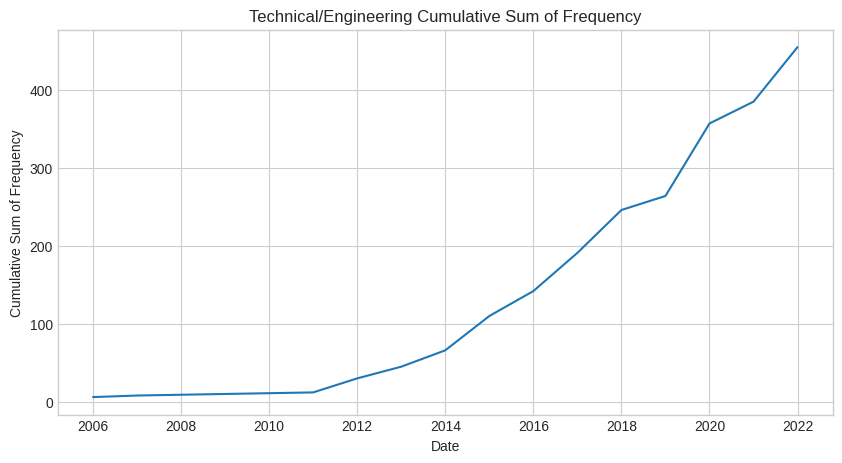

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


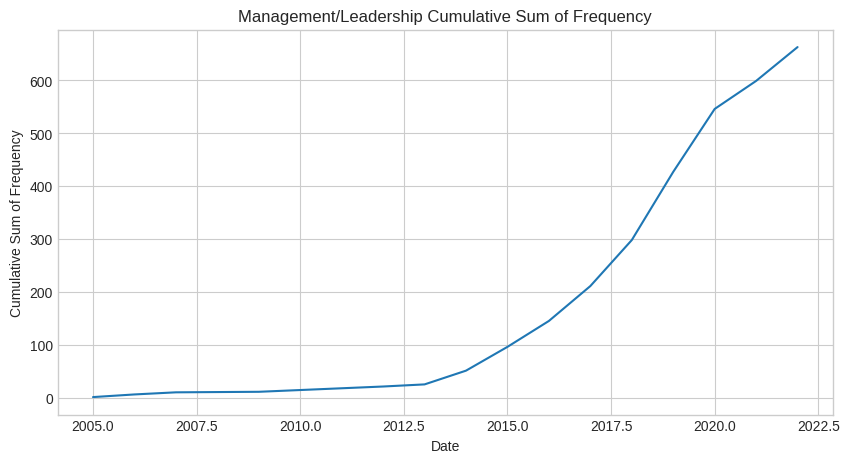

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


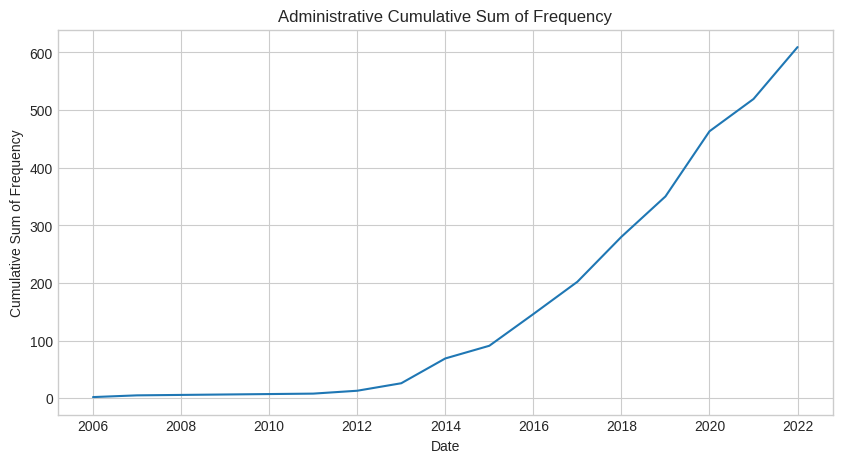

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


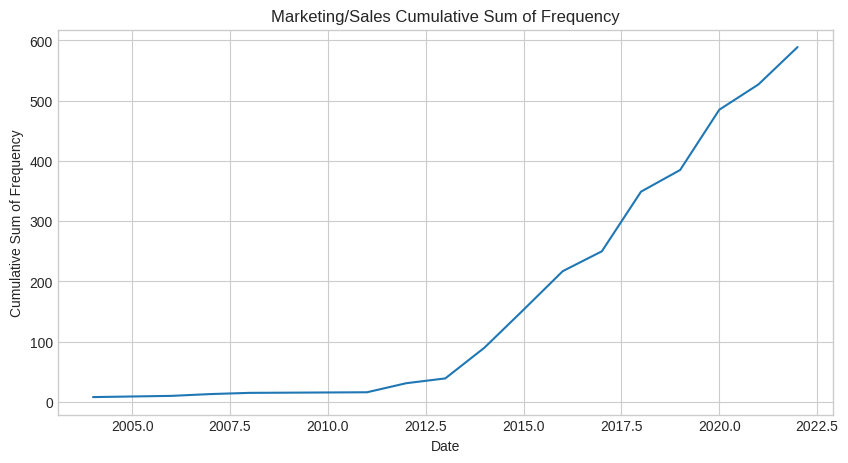

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


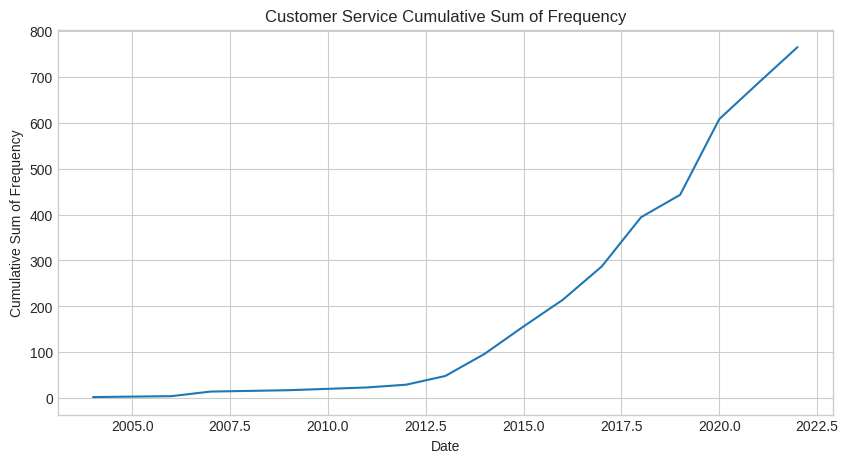

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


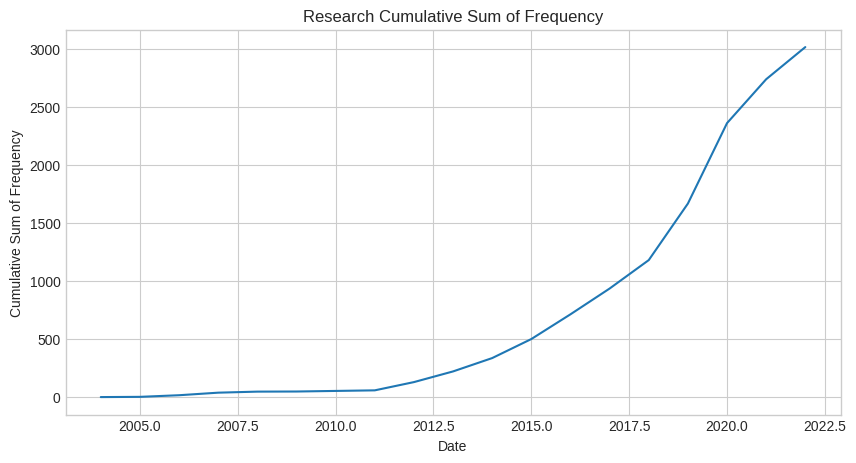

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


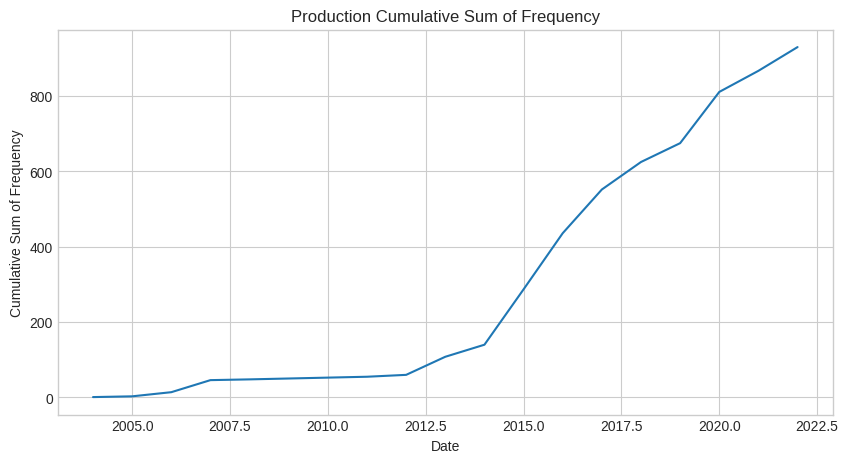

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


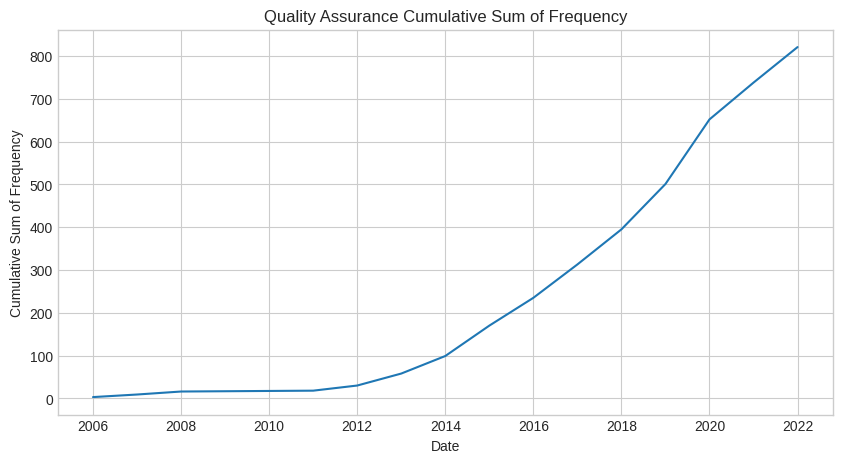

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


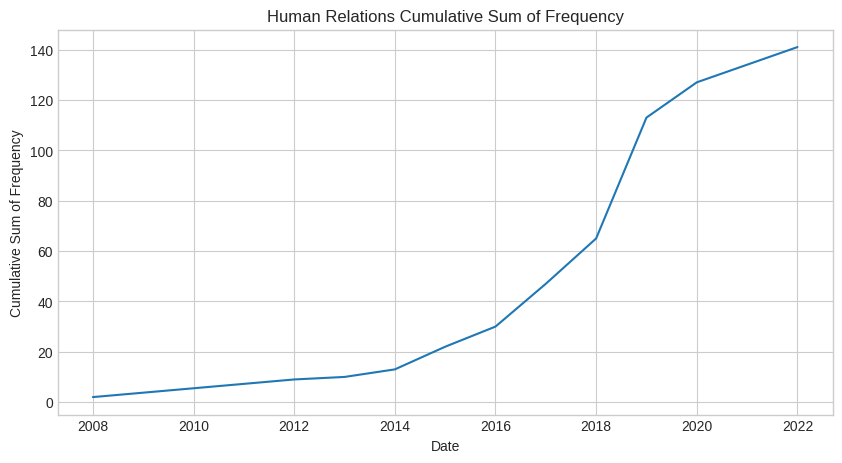

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


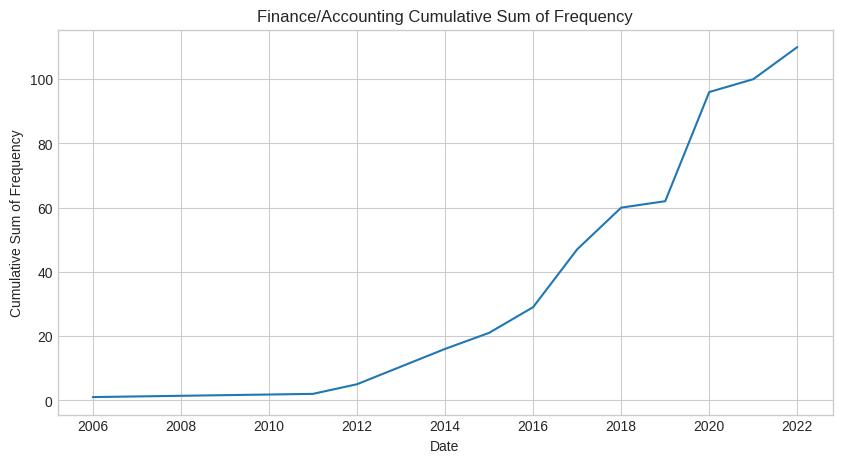

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


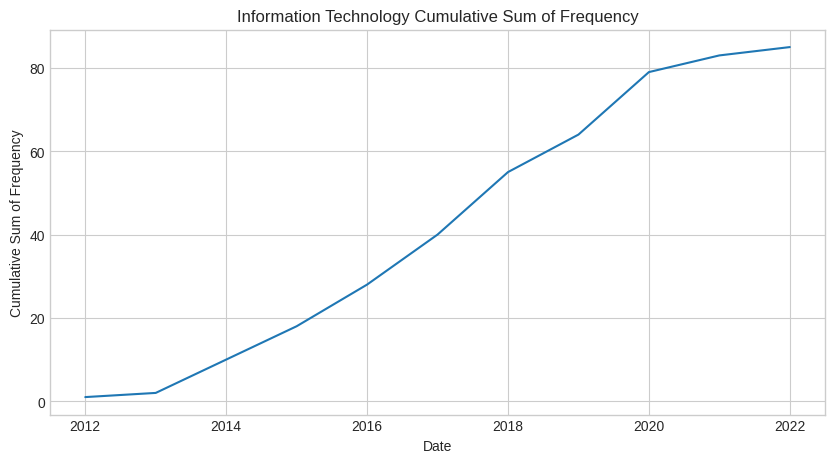

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


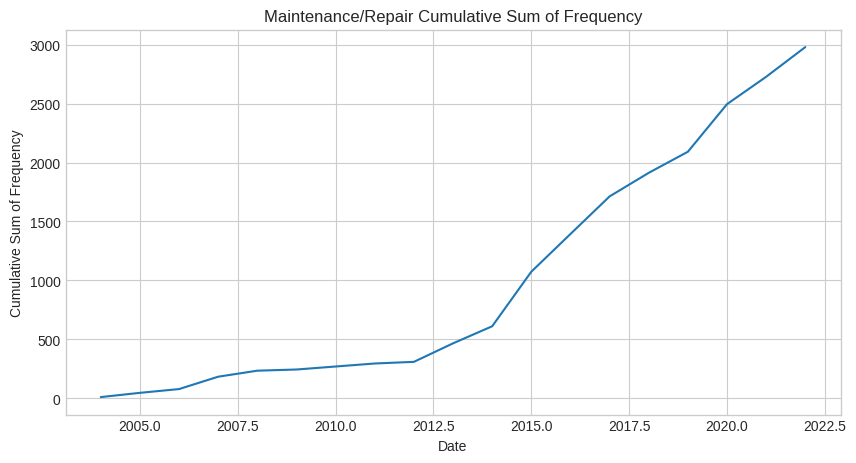

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


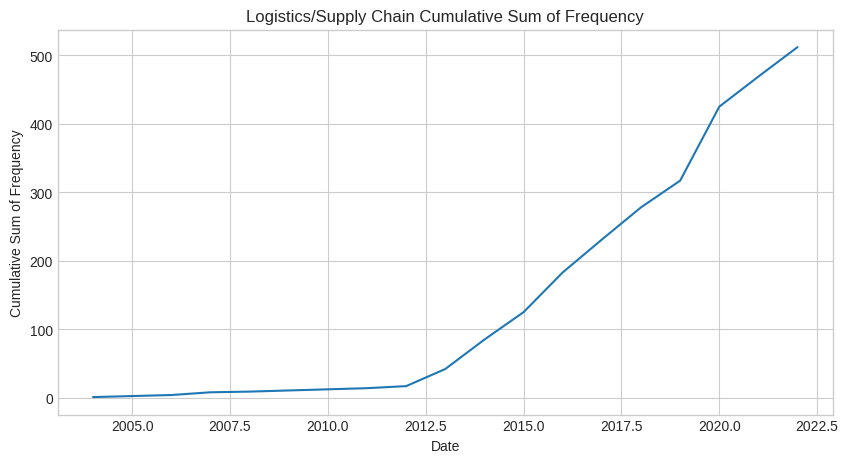

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


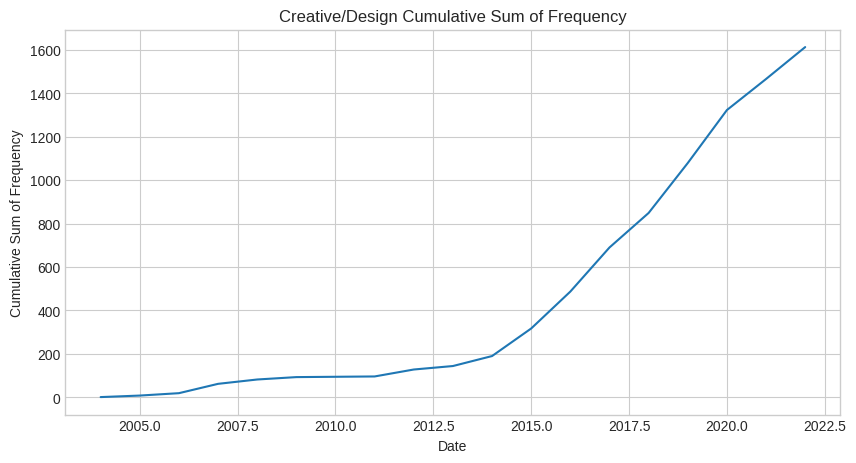

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


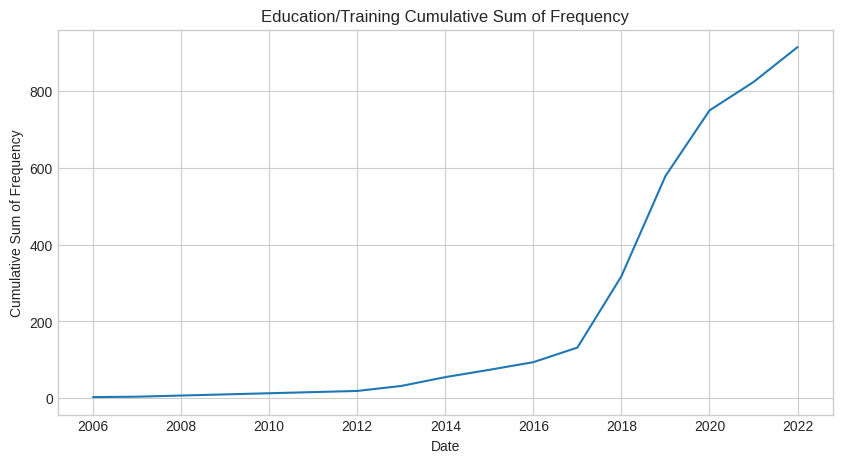

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


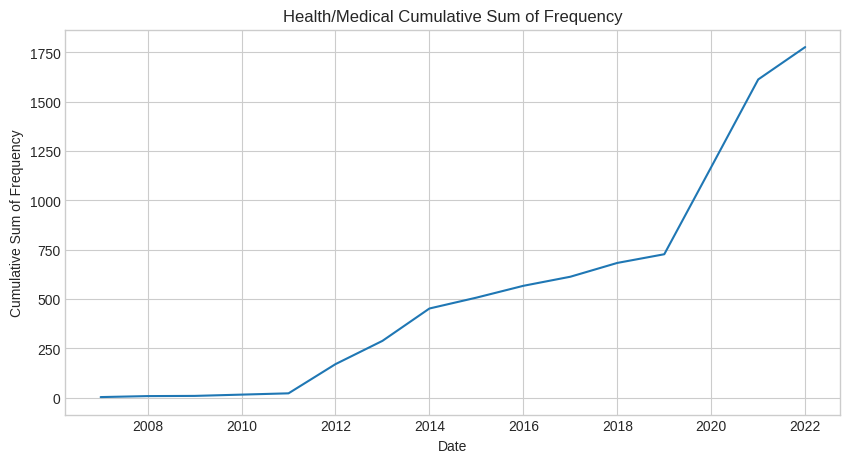

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


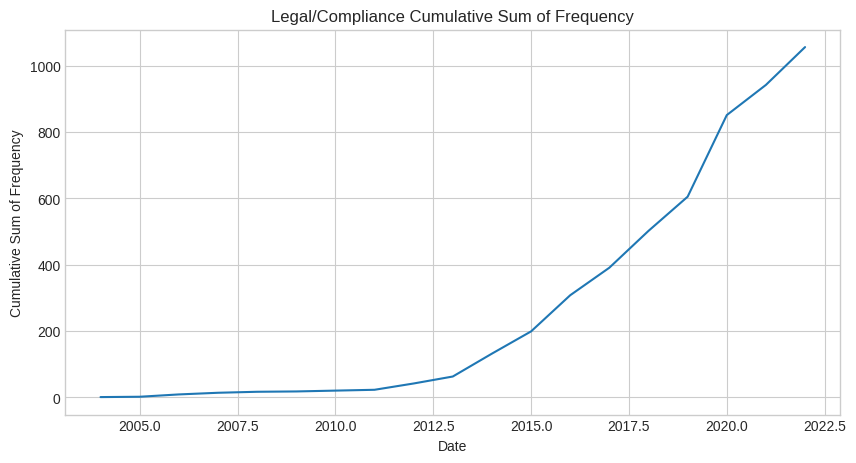

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


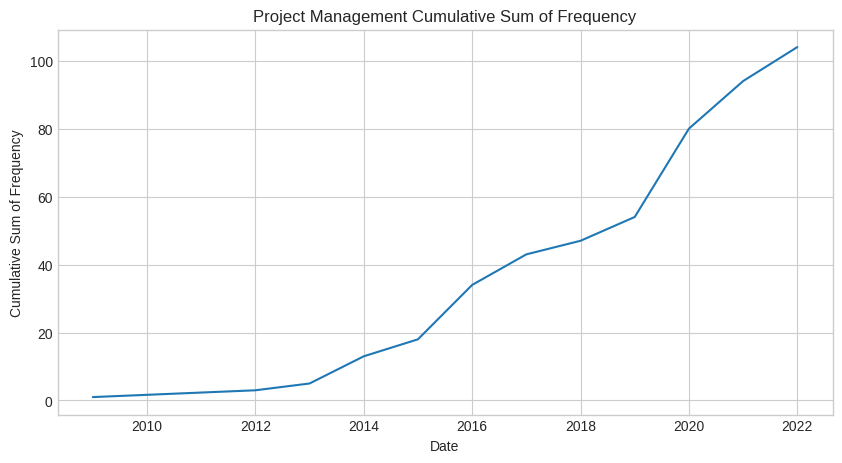

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


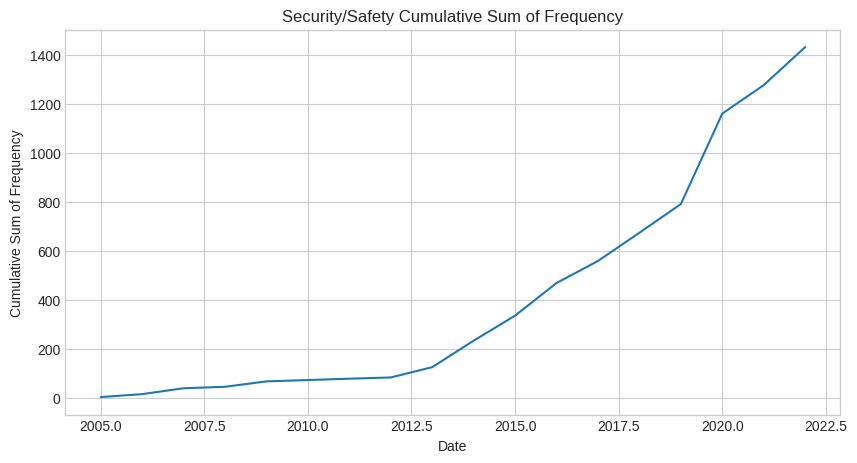

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


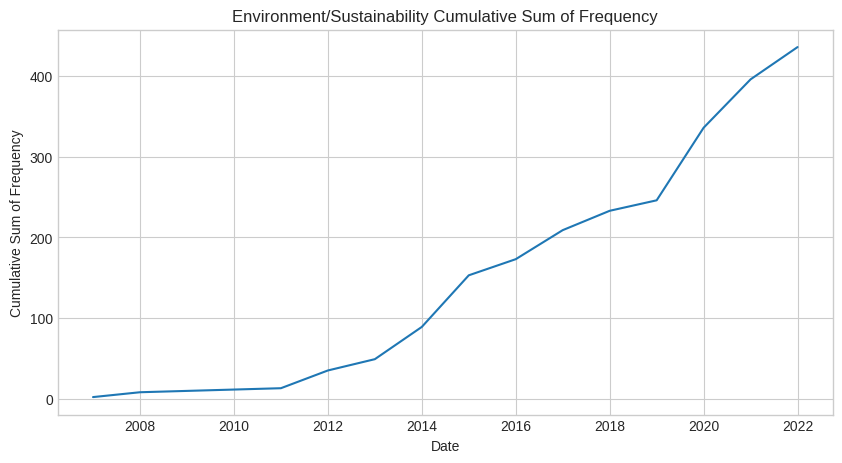

<ipython-input-8-2d247b053bc9>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


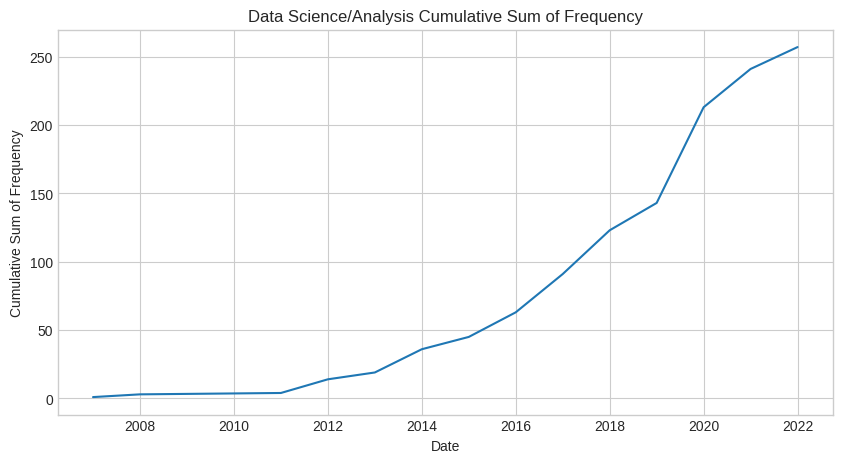

    Date  Frequency
0   2004          1
1   2005          2
2   2006         14
3   2007         22
4   2008          9
5   2009          1
6   2011         10
7   2012         71
8   2013         92
9   2014        115
10  2015        164
11  2016        213
12  2017        222
13  2018        245
14  2019        487
15  2020        693
16  2021        378
17  2022        277


In [9]:
# Plot graphs for all 21 categories cummulative sum
df_dict = {}
for item in cat_mapping.values():
  df_dict[item] = plot_cumsum(item)
print(df_dict["Research"])

As you can see, it is clear that Research, Data Science, and Engineering tasks amongst the US job market have increased in a somewhat exponential matter, however this can be scrutinized greatly. Concidering that ONET has sparse data from previous years, specifically from 2006 to 2012 there is not that much unfortunatly. However there is a silver lining. Using ONET's data on emerging tasks, we can analyze the total change in time, A.K.A. the derivative of the cummaltive sum over time. Additionally take notice of health and medicine plots, there is a dramatic increase in jobs that require health/medicine tasks to be done between 2020 and 2021, this can explored further in its correlation with the Covid-19 outbreak.

# Rate of Change and Cummulative Percent
I will calculate the cummulative percent and rate of change and proceed to do a comparison analysis with each category, and see which categories of jobs are increasing the highest which was the purpose of the analysis. The reason I calculate cummulative percent is just to provide another way of understanding whats going on with the data. Keep in mind that the years before 2012 and its data can be more or less disregarded.

In [10]:
# Get rate of change as a percentage, meaning that the ROC column will calculate the ROC between each year consecutively
for category_df in df_dict.values():
  category_df['ROC'] = category_df['Frequency'].pct_change()
  category_df['Cumulative Percent'] = 100 * (category_df['Frequency'].cumsum() / category_df['Frequency'].sum())
  category_df['Cumulative Sum'] = category_df['Frequency'].cumsum()
  category_df.set_index
df_dict['Research']



,Date,Frequency,ROC,Cumulative Percent,Cumulative Sum
0,2004,1,NaN,0.033156,1
1,2005,2,1.000000,0.099469,3
2,2006,14,6.000000,0.563660,17
3,2007,22,0.571429,1.293103,39
4,2008,9,-0.590909,1.591512,48
5,2009,1,-0.888889,1.624668,49
6,2011,10,9.000000,1.956233,59
7,2012,71,6.100000,4.310345,130
8,2013,92,0.295775,7.360743,222
9,2014,115,0.250000,11.173740,337


In [22]:
derivatives = {}
for item in df_dict.keys():
  data = df_dict[item]['ROC']
  year = df_dict[item]['Date']
  derivatives[item] = pd.Series(data=data.values, index=year.values,name='Date')

derivative_df = pd.DataFrame.from_dict(derivatives, orient='columns')

# Sort columns (years) in ascending order
derivative_df = derivative_df.reindex(sorted(derivative_df.columns), axis=1)

# Fill missing values with 'na'
derivative_df = derivative_df.fillna("NA")
derivative_df = derivative_df.iloc[8:]
derivative_df

,Administrative,Creative/Design,Customer Service,Data Science/Analysis,Education/Training,Environment/Sustainability,Finance/Accounting,Health/Medical,Human Relations,Information Technology,...,Logistics/Supply Chain,Maintenance/Repair,Management/Leadership,Marketing/Sales,Production,Project Management,Quality Assurance,Research,Security/Safety,Technical/Engineering
2013,1.6,-0.5,2.166667,-0.5,-0.133333,-0.363636,NA,-0.202703,-0.857143,0.0,...,7.333333,10.214286,-0.6,-0.466667,8.6,0.0,1.333333,0.295775,7.4,-0.166667
2014,2.307692,1.875,1.526316,2.4,0.769231,1.857143,2.666667,0.389831,2.0,7.0,...,0.72,-0.076433,5.5,5.375,-0.333333,3.0,0.464286,0.25,1.571429,0.4
2015,-0.488372,1.76087,0.25,-0.470588,-0.173913,0.6,-0.545455,-0.664634,2.0,0.0,...,-0.069767,2.193103,0.730769,0.235294,3.59375,-0.375,0.731707,0.426087,-0.055556,1.095238
2016,1.5,0.338583,-0.033333,1.0,0.052632,-0.6875,0.6,0.090909,-0.111111,0.25,...,0.45,-0.308855,0.088889,0.015873,0.013605,2.2,-0.084507,0.29878,0.303922,-0.272727
2017,0.018182,0.194118,0.258621,0.555556,0.9,0.8,1.25,-0.233333,1.125,0.2,...,-0.172414,-0.003125,0.346939,-0.484375,-0.221477,-0.4375,0.2,0.042254,-0.323308,0.53125
2018,0.392857,-0.216749,0.465753,0.142857,3.894737,-0.333333,-0.277778,0.521739,0.058824,0.25,...,-0.020833,-0.373041,0.318182,2.0,-0.37069,-0.555556,0.051282,0.103604,0.277778,0.122449
2019,-0.102564,0.446541,-0.542056,-0.375,0.403226,-0.458333,-0.846154,-0.371429,1.666667,-0.4,...,-0.170213,-0.105,0.482759,-0.636364,-0.315068,0.75,0.292683,0.987755,0.017391,-0.672727
2020,0.614286,0.06087,2.367347,2.5,-0.344828,5.923077,16.0,9.045455,-0.708333,0.666667,...,1.769231,1.256983,-0.077519,1.777778,1.72,2.714286,0.424528,0.422998,2.153846,4.166667
2021,-0.504425,-0.413934,-0.521212,-0.6,-0.567251,-0.333333,-0.882353,0.004525,-0.5,-0.733333,...,-0.592593,-0.425743,-0.554622,-0.58,-0.588235,-0.461538,-0.430464,-0.454545,-0.685637,-0.698925
2022,0.607143,0.027972,-0.012658,-0.428571,0.22973,-0.333333,1.5,-0.630631,0.0,-0.5,...,-0.022727,0.086207,0.207547,0.47619,0.125,-0.285714,-0.034884,-0.267196,0.336207,1.5


# Conclusion and what I can take away when working with ONET and results
## Pros and Cons about ONET
* Pros:
  * ONET is extremely easy to understand and use
  * Can easily work it in python
* Cons:
  * Too little data on years from 2004-2012, its quite simply dissapointing as I cannot work with it, and can only reasonably work with data from 2013 and higher, and even then 2013 is not the best
  * The data can be scrutinized to a reasonable extent, its clear to me that if there are rapid increases in the frequency of a task based upon its category, it can mean two things:
  
      1. Either it is accurate and corresponds to what one would think is reasonably true
      2. There is simply not enough data in that year to mitigate that jump
  * Generally speaking the former is true, however the ladder happened frequently with data from 2004-2012

# What I did to analyze this data: a summary

I first started out with ONET's "Task Statements" excel sheet, this contained about 19000 rows of task statements with its corresponding occupation and the date it was recorded.

I then moved on to preprocessing and performed the following steps:

1. Remove irrelavent columns from the dataframe (SOC CODE, Domain, Data source, etc)
2. I converted the "Date" column of the dataframe into a python datetime object
3. I then created a new column in the dataframe called "Processed tasks". This was added to the original dataframe and therefore is quite messy. This was simply all the task statements in the dataframe that went through the heavy preprocessing steps I took:
    * Remove all the special characters
    * Remove all single characters
    * Remove single characters from the start
    * Substituting multiple spaces with single space
    * Removing prefixed 'b'
    * Converting to Lowercase
    * Lemmatization

These steps seem quite heavy and *very* thorough. I don't really think I needed that much, but its a lot of statements so why not?

### Clustering

The following section is the first thing I decided to do to work with this data. **It is important to note** that I already knew that I wanted to analyze the frequency of tasks over a time series due to being given the dates the data was recorded. This was also the only option I saw when figuring out what to do with this data.

So what I thought of first was to use K-Means clustering to cluster task statements based upon its **textual similarity**, meaning that I will have 20 clusters because I want to group things into 20 job categories (I will explain more later on). How I did the clustering is using TF-IDF which is a one-hot encoding method. **However, I will be changing this to word embeddings using fasttext** after I officially finish my research and analysis of burning glass data, which will be the "flag ship" of my research hopefully!

The purpose of this clustering was to ensure that no extreme overlap or collisions with the text is made and to ensure that all the data in its cluster is unique enough such that it will be reasonably similar to other text found in its designated cluster. [This excellent resource really helped me out.](https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20)

The results of the cluster distribution were satisfactory to me, no relative overlap in data, and all clusters have a unique enough value that all data within it would be considered very similar.

### Natural Language Processing and Categorization

Moving on from clustering, the main thing I planned to do with the data is to use natural langauge processing to categorize job tasks. For these purposes I used a [zero shot classification model from huggingface](https://huggingface.co/tasks/zero-shot-classification). This model is pretrained and huggingface's reputation for state of the art NLP models convinced me into using it. I couldn't train my own as I have no data to train on. The total training took about 3-4 hours on google colabs free GPU. I was satisfied with the results and saved it to an excel sheet made avaliable

### Frequency analysis

After catergorizing tasks, I creating a new dataframe with their relative frequency. **It is important to note:** Due to ONET's lack of data from 2004-2012, the data generated from it can be reasonably discarded as it is not interesting or useful. The dataframe gave me the data in months, so what I did was calculate some descriptive statistics
